In [1]:
import os
import glob
import itertools
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

plt.style.use('seaborn')

/var/folders/87/1xfj2sq155s0_ncvvpdrsb_w0000gn/T/ipykernel_72745/330273921.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#抽样函数
def sample_categories(root_path, n_samples=2):
    """按视角数量抽样类别"""
    # 统计所有类别的视角数量
    categories = []
    for cat in os.listdir(root_path):
        views = glob.glob(os.path.join(root_path, cat, "*.jpg"))
        categories.append({
            "path": os.path.join(root_path, cat),
            "n_views": len(views),
            "view_names": [os.path.basename(v).split('.')[0] for v in views]
        })
    
    # 按视角数量分组抽样
    sampled = {}
    for n in [3, 4, 5]:
        eligible = [c for c in categories if c["n_views"] == n]
        sampled[n] = np.random.choice(eligible, size=min(n_samples, len(eligible)), replace=False)
    return sampled

In [3]:
#相似度计算
def calculate_view_similarity(sampled_cats):
    """计算抽样类别的视角相似度"""
    results = []
    for n_views, cats in sampled_cats.items():
        for cat in cats:
            images = sorted(glob.glob(os.path.join(cat["path"], "*.jpg")))
            
            # 计算所有视角组合
            for (i, j) in itertools.combinations(range(len(images)), 2):
                img1 = cv2.imread(images[i])
                img2 = cv2.imread(images[j])
                
                # 统一尺寸加速计算
                img1 = cv2.resize(img1, (256, 256))
                img2 = cv2.resize(img2, (256, 256))
                
                ssim_val = ssim(img1, img2, channel_axis=2)
                psnr = cv2.PSNR(img1, img2)
                
                results.append({
                    "category": os.path.basename(cat["path"]),
                    "n_views": n_views,
                    "view_pair": f"{cat['view_names'][i]}-{cat['view_names'][j]}",
                    "ssim": ssim_val,
                    "psnr": psnr
                })
    return pd.DataFrame(results)

In [4]:
#运行实验
# 参数设置
dataset_path = "uob_image_set"  # 替换为实际路径
sampled_cats = sample_categories(dataset_path, n_samples=2)
results_df = calculate_view_similarity(sampled_cats)

# 保存结果
results_df.to_csv("view_similarity_samples.csv", index=False)
print(results_df.head())

   category  n_views              view_pair      ssim       psnr
0  16173972        3  16173972_0-16173972_1  0.757983  13.801293
1  16173972        3  16173972_0-16173972_2  0.684907  12.546789
2  16173972        3  16173972_1-16173972_2  0.634048  11.959836
3  16021558        3  16021558_2-16021558_0  0.205366   3.574325
4  16021558        3  16021558_2-16021558_1  0.798894  12.707681


可视化分析

In [5]:
#热力图
def plot_single_category_heatmap(df, category_name):
    cat_data = df[df["category"] == category_name]
    views = sorted(set(cat_data["view_pair"].str.split('-').explode()))
    
    # 创建相似度矩阵
    sim_matrix = pd.DataFrame(np.eye(len(views)), index=views, columns=views)
    for _, row in cat_data.iterrows():
        v1, v2 = row["view_pair"].split('-')
        sim_matrix.loc[v1, v2] = row["ssim"]
        sim_matrix.loc[v2, v1] = row["ssim"]
    
    # 绘制
    plt.figure(figsize=(6, 5))
    sns.heatmap(sim_matrix, annot=True, cmap="YlOrRd", vmin=0, vmax=1)
    plt.title(f"View Similarity: {category_name}\n({len(views)} views)")
    plt.tight_layout()
    plt.savefig(f"heatmap_{category_name}.png", dpi=120)
    plt.close()

# 为每个抽样类别生成热力图
for cat in results_df["category"].unique():
    plot_single_category_heatmap(results_df, cat)

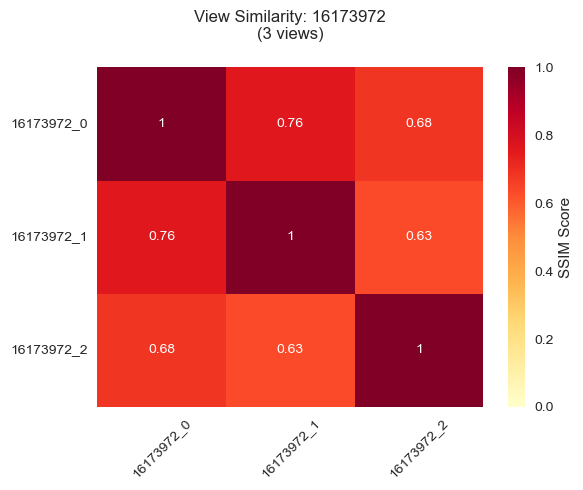

In [7]:
def show_single_category_heatmap(df, category_name):
    cat_data = df[df["category"] == category_name]
    views = sorted(set(cat_data["view_pair"].str.split('-').explode()))
    
    # 创建相似度矩阵
    sim_matrix = pd.DataFrame(np.eye(len(views)), index=views, columns=views)
    for _, row in cat_data.iterrows():
        v1, v2 = row["view_pair"].split('-')
        sim_matrix.loc[v1, v2] = row["ssim"]
        sim_matrix.loc[v2, v1] = row["ssim"]
    
    # 直接显示
    plt.figure(figsize=(6, 5))
    sns.heatmap(sim_matrix, annot=True, cmap="YlOrRd", vmin=0, vmax=1, 
                cbar_kws={'label': 'SSIM Score'})
    plt.title(f"View Similarity: {category_name}\n({len(views)} views)", pad=20)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 示例调用
show_single_category_heatmap(results_df, results_df["category"].iloc[0])  # 显示第一个类别

In [6]:
#箱线图
def plot_cross_category_comparison(df):
    plt.figure(figsize=(10, 5))
    
    # SSIM对比
    plt.subplot(121)
    sns.boxplot(data=df, x="n_views", y="ssim", palette="Set2")
    plt.title("SSIM by View Numbers")
    plt.ylim(0, 1)
    
    # PSNR对比
    plt.subplot(122)
    sns.boxplot(data=df, x="n_views", y="psnr", palette="Set2")
    plt.title("PSNR by View Numbers")
    
    plt.tight_layout()
    plt.savefig("cross_category_comparison.png", dpi=150)
    #plt.close()

plot_cross_category_comparison(results_df)

In [ ]:
#视角对分析
def plot_view_pair_analysis(df):
    # 统计常见视角对的平均相似度
    view_pair_stats = df.groupby("view_pair")["ssim"].agg(['mean', 'count'])
    view_pair_stats = view_pair_stats[view_pair_stats['count'] > 1]  # 过滤低频组合
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=view_pair_stats.index, 
        y="mean", 
        data=view_pair_stats.reset_index(),
        palette="viridis"
    )
    plt.xticks(rotation=45)
    plt.title("Average SSIM by View Pairs (with sample count)")
    
    # 添加样本数标注
    for i, (_, row) in enumerate(view_pair_stats.iterrows()):
        plt.text(i, row['mean']+0.02, f"n={row['count']}", ha='center')
    
    plt.tight_layout()
    plt.savefig("view_pair_analysis.png", dpi=150)
    plt.close()

plot_view_pair_analysis(results_df)

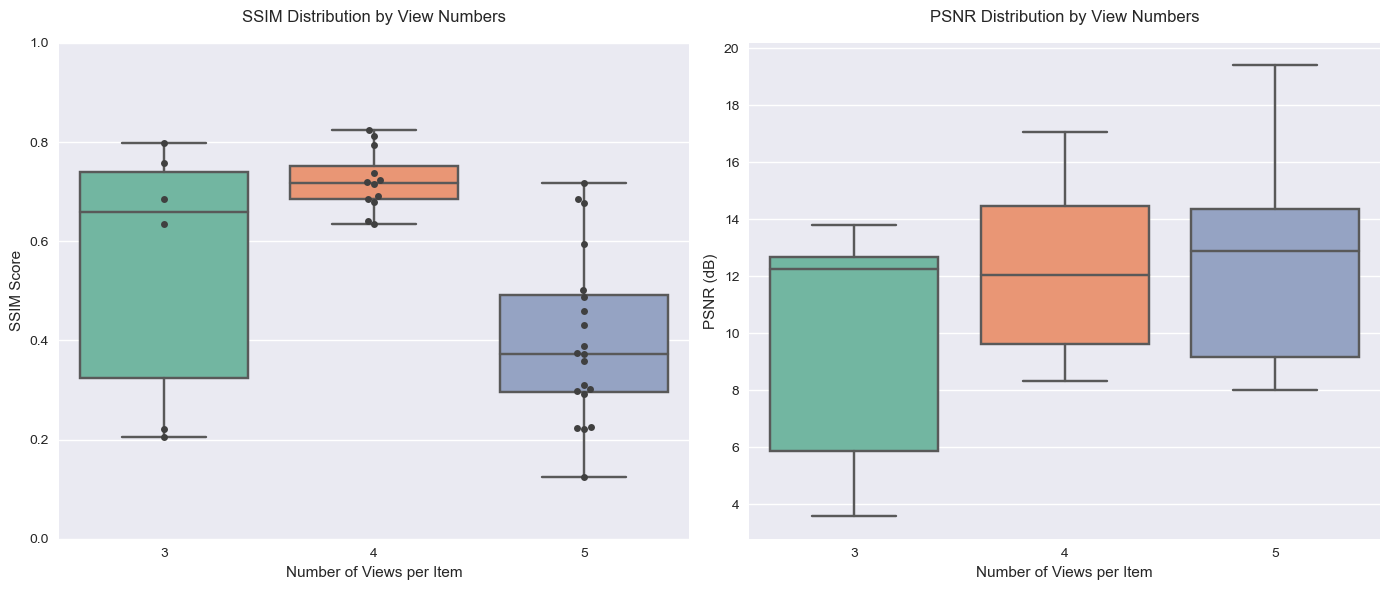

In [8]:
#直接输出
def show_cross_category_comparison(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # SSIM对比
    sns.boxplot(data=df, x="n_views", y="ssim", palette="Set2", ax=ax1)
    ax1.set_title("SSIM Distribution by View Numbers", pad=15)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Number of Views per Item")
    ax1.set_ylabel("SSIM Score")
    
    # 添加数据点
    sns.swarmplot(data=df, x="n_views", y="ssim", color=".25", size=5, ax=ax1)
    
    # PSNR对比
    sns.boxplot(data=df, x="n_views", y="psnr", palette="Set2", ax=ax2)
    ax2.set_title("PSNR Distribution by View Numbers", pad=15)
    ax2.set_xlabel("Number of Views per Item")
    ax2.set_ylabel("PSNR (dB)")
    
    plt.tight_layout()
    plt.show()

show_cross_category_comparison(results_df)

/var/folders/87/1xfj2sq155s0_ncvvpdrsb_w0000gn/T/ipykernel_72745/3459614122.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(


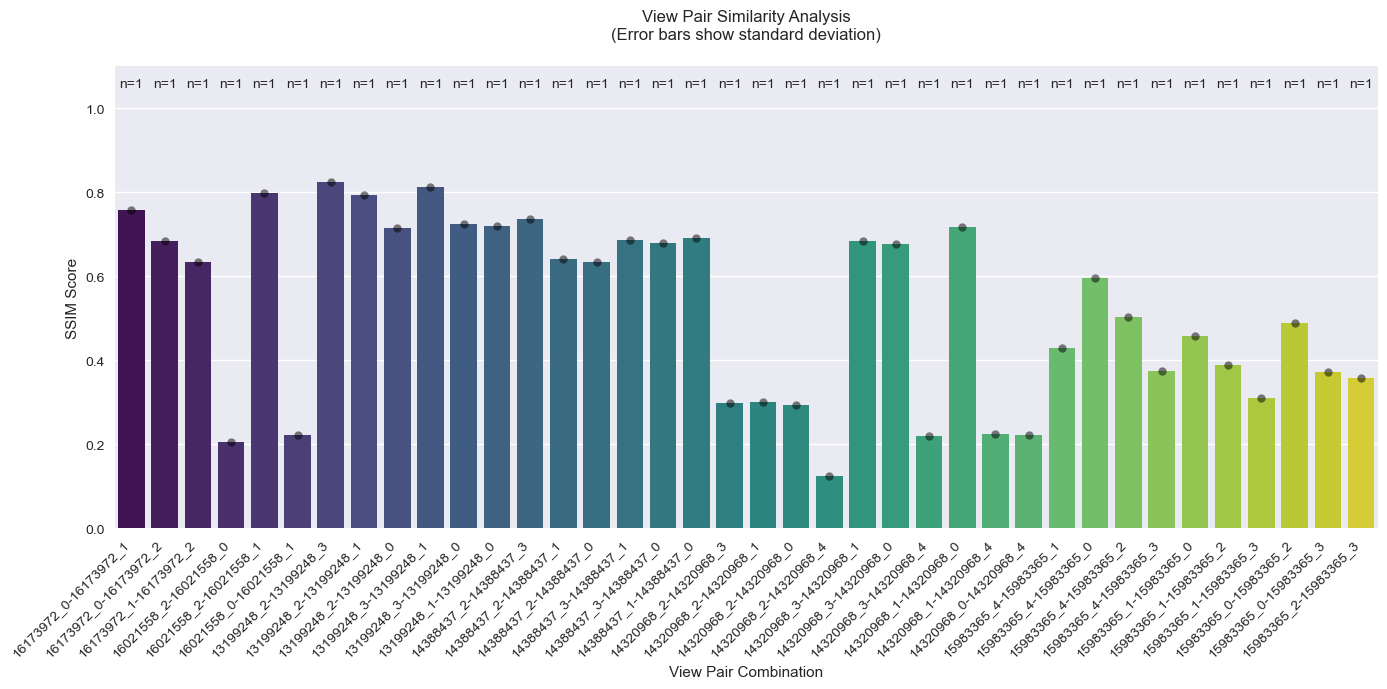

In [9]:
def show_view_pair_analysis(df):
    plt.figure(figsize=(14, 7))
    
    # 使用柱状图+散点图组合
    ax = sns.barplot(
        x="view_pair", 
        y="ssim", 
        data=df,
        palette="viridis",
        ci="sd",  # 显示标准差
        capsize=0.1
    )
    
    # 叠加原始数据点
    sns.stripplot(
        x="view_pair", 
        y="ssim", 
        data=df,
        color="black",
        size=6,
        alpha=0.5,
        jitter=True
    )
    
    plt.title("View Pair Similarity Analysis\n(Error bars show standard deviation)", pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.ylabel("SSIM Score")
    plt.xlabel("View Pair Combination")
    
    # 添加样本数标注
    for i, pair in enumerate(df["view_pair"].unique()):
        count = len(df[df["view_pair"] == pair])
        plt.text(i, 1.05, f"n={count}", ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

show_view_pair_analysis(results_df)